# 画像をロード

In [1]:
from glob import glob

import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
files = pd.DataFrame(glob("../images/*_*.jpg"), columns = ["filename"])

files[["id", "kind"]] = files["filename"].str.extract("(\d+)_([xy])\.jpg")
files["id"] = files["id"].astype(int)

ids = np.sort(files["id"].unique())

files = files.sort_values(['id', 'kind']).set_index(['id', 'kind'])

files[:4]

filename
id kind                    
1  x     ../images/01_x.jpg
   y     ../images/01_y.jpg
2  x     ../images/02_x.jpg
   y     ../images/02_y.jpg

In [3]:
images = {}
for i, row in files.iterrows():
    images[row.filename] = cv2.imread(row.filename)
    

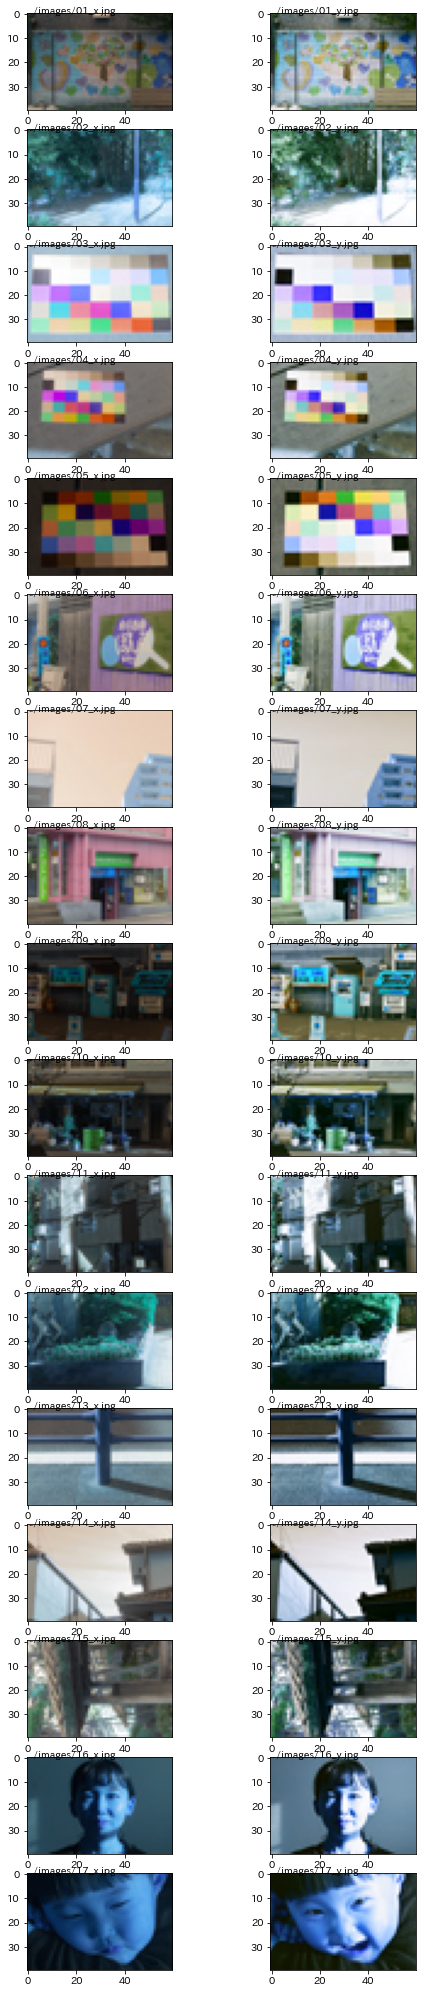

In [4]:


plt.figure(figsize=(8,36))
j = 0
for (i, k), row in files.iterrows():
    j += 1
    
    plt.subplot(ids.size, 2, j)
    plt.imshow(images[row.filename])
    plt.text(0, 0, row.filename)


# とりあえず変換を可視化してみる。


* 入力側の画素の色をRGB空間にプロット
* 変換後にその色がどう変化しているかを線で表現
* 画像から学習ができそうかを検討してみる。

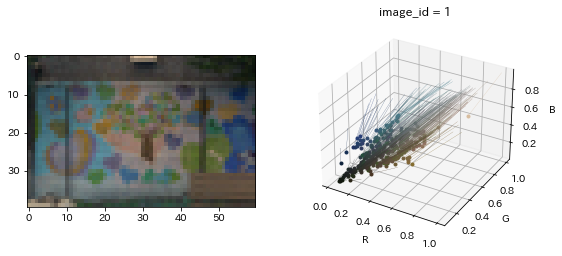

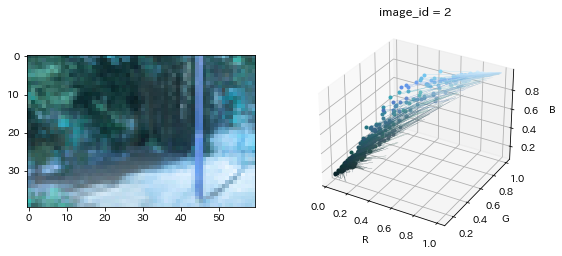

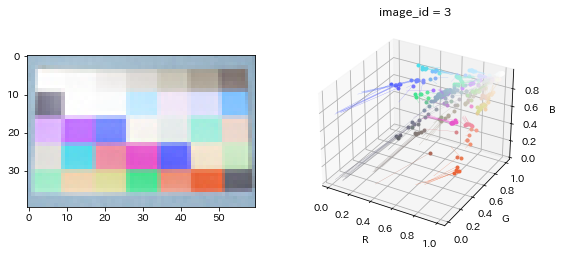

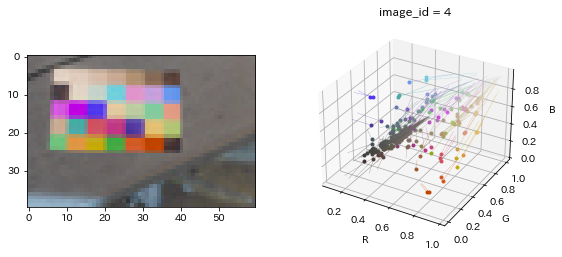

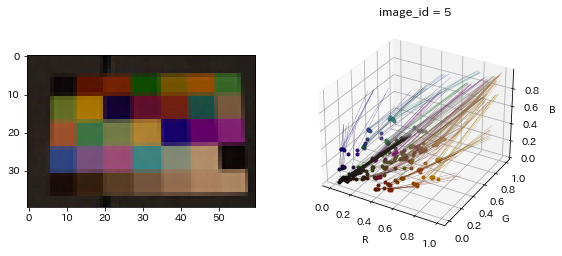

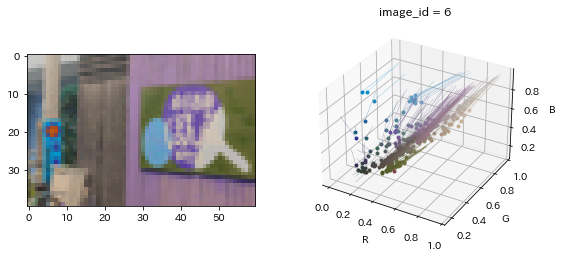

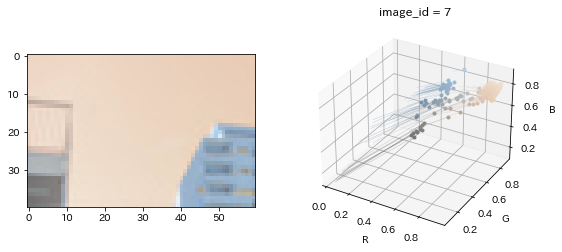

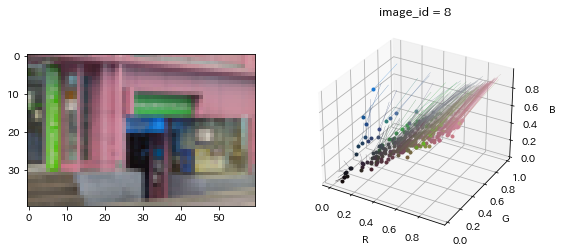

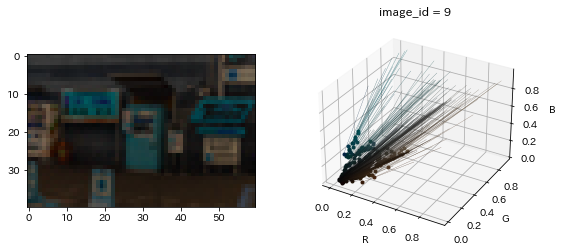

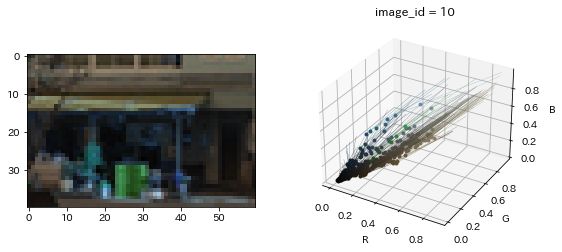

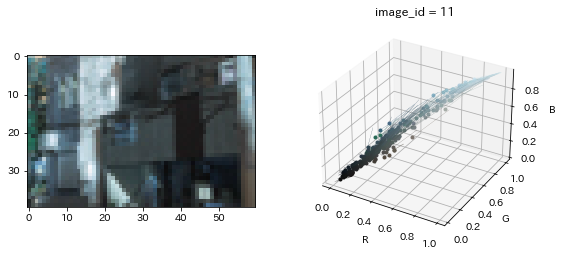

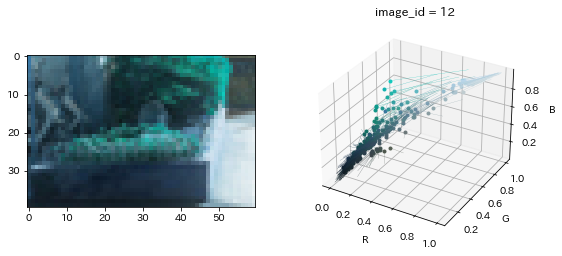

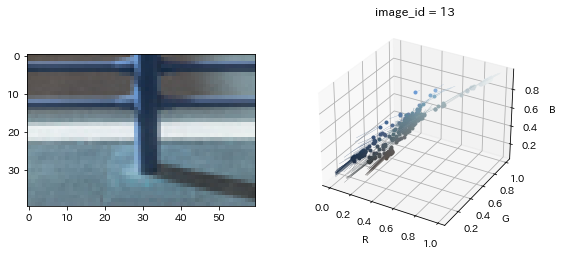

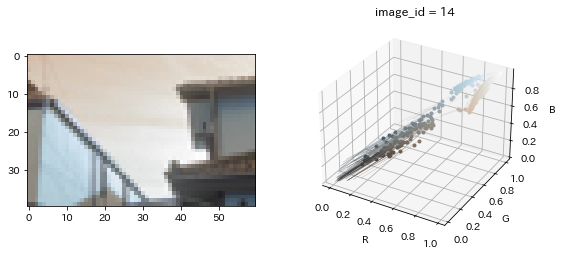

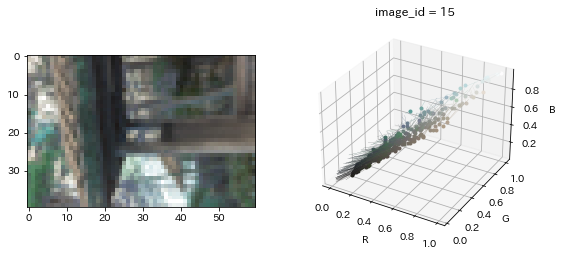

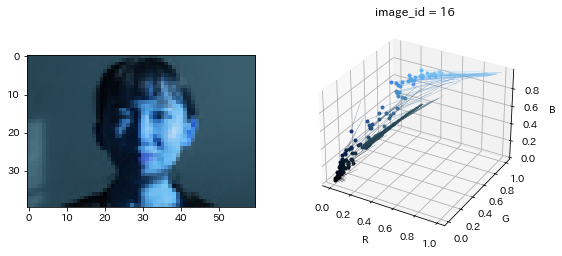

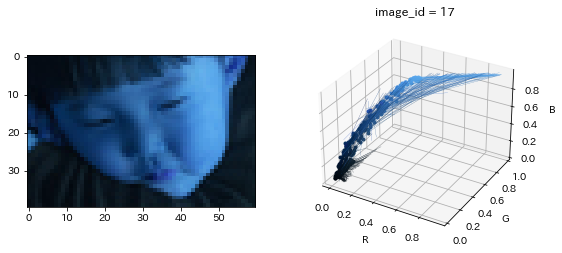

In [5]:
for image_id in ids:
    plt.figure(figsize=(9,4))
    skips = 7

    image_x =  images[files.loc[(image_id, 'x'), 'filename']]
    image_y =  images[files.loc[(image_id, 'y'), 'filename']]

    ax1 = plt.subplot(121)

    plt.imshow(image_x)


    ax2 = plt.subplot(122, projection='3d')

    im_x = image_x.reshape(-1, 3)[::skips]/256.0
    im_y = image_y.reshape(-1, 3)[::skips]/256.0

    for r,g,b in im_x:
        plt.plot(r,g,b, '.', color=[r,g,b])

    for i, (rx, gx, bx) in enumerate(im_x):
        ry, gy, by = im_y[i]
        plt.plot([rx, ry], [gx, gy], [bx, by], color=[rx,gx,bx], lw=0.2)

    ax2.set_xlabel('R')
    ax2.set_ylabel('G')
    ax2.set_zlabel('B')

    ax2.set_title(f'image_id = {image_id}')

    plt.show()

# とりあえずわかること


### 色 → 色 (RGBでもHSVでもHLSでもよいが) の変換だと考えて良さそう。

* それぞれの画像において、近い色は変換先も近い色である。
* 1つの画像においては、RGB空間における連続的な変換として考えて良さそう。
* これは当たり前だが、一応確認できた。
    
### 写真1枚でRGBの全空間に渡って変換を推定するのは難しい。

* 実際の写真はRGB空間において3次元的な広がりをもつというより、むしろ2次元の多様体のようなものである。
    * とくに、色相が1方向に偏りがちなのと、彩度の変化はあまり大きくない。
    * 2次元多様体と垂直な方向についての情報は何も得られないため、1枚の画像から変換を学習するのは無理そう。
    
* カラーパターンを使えば色相方向の空間を埋め尽くせる。しかし、明度が一定になりがち。
    * いろんな色相・彩度のカラーパターンをいろんな明度で撮影するなどして学習データを集めないとうまくいかなさそう。

### 複数写真を集めるのならば、露光をうまいこと揃える必要がある。
    
画像によって変換前後の全体的な明るさが違う。
例えば、image_id = 06, 07 では、赤丸で囲った部分で反対の動きをしている。

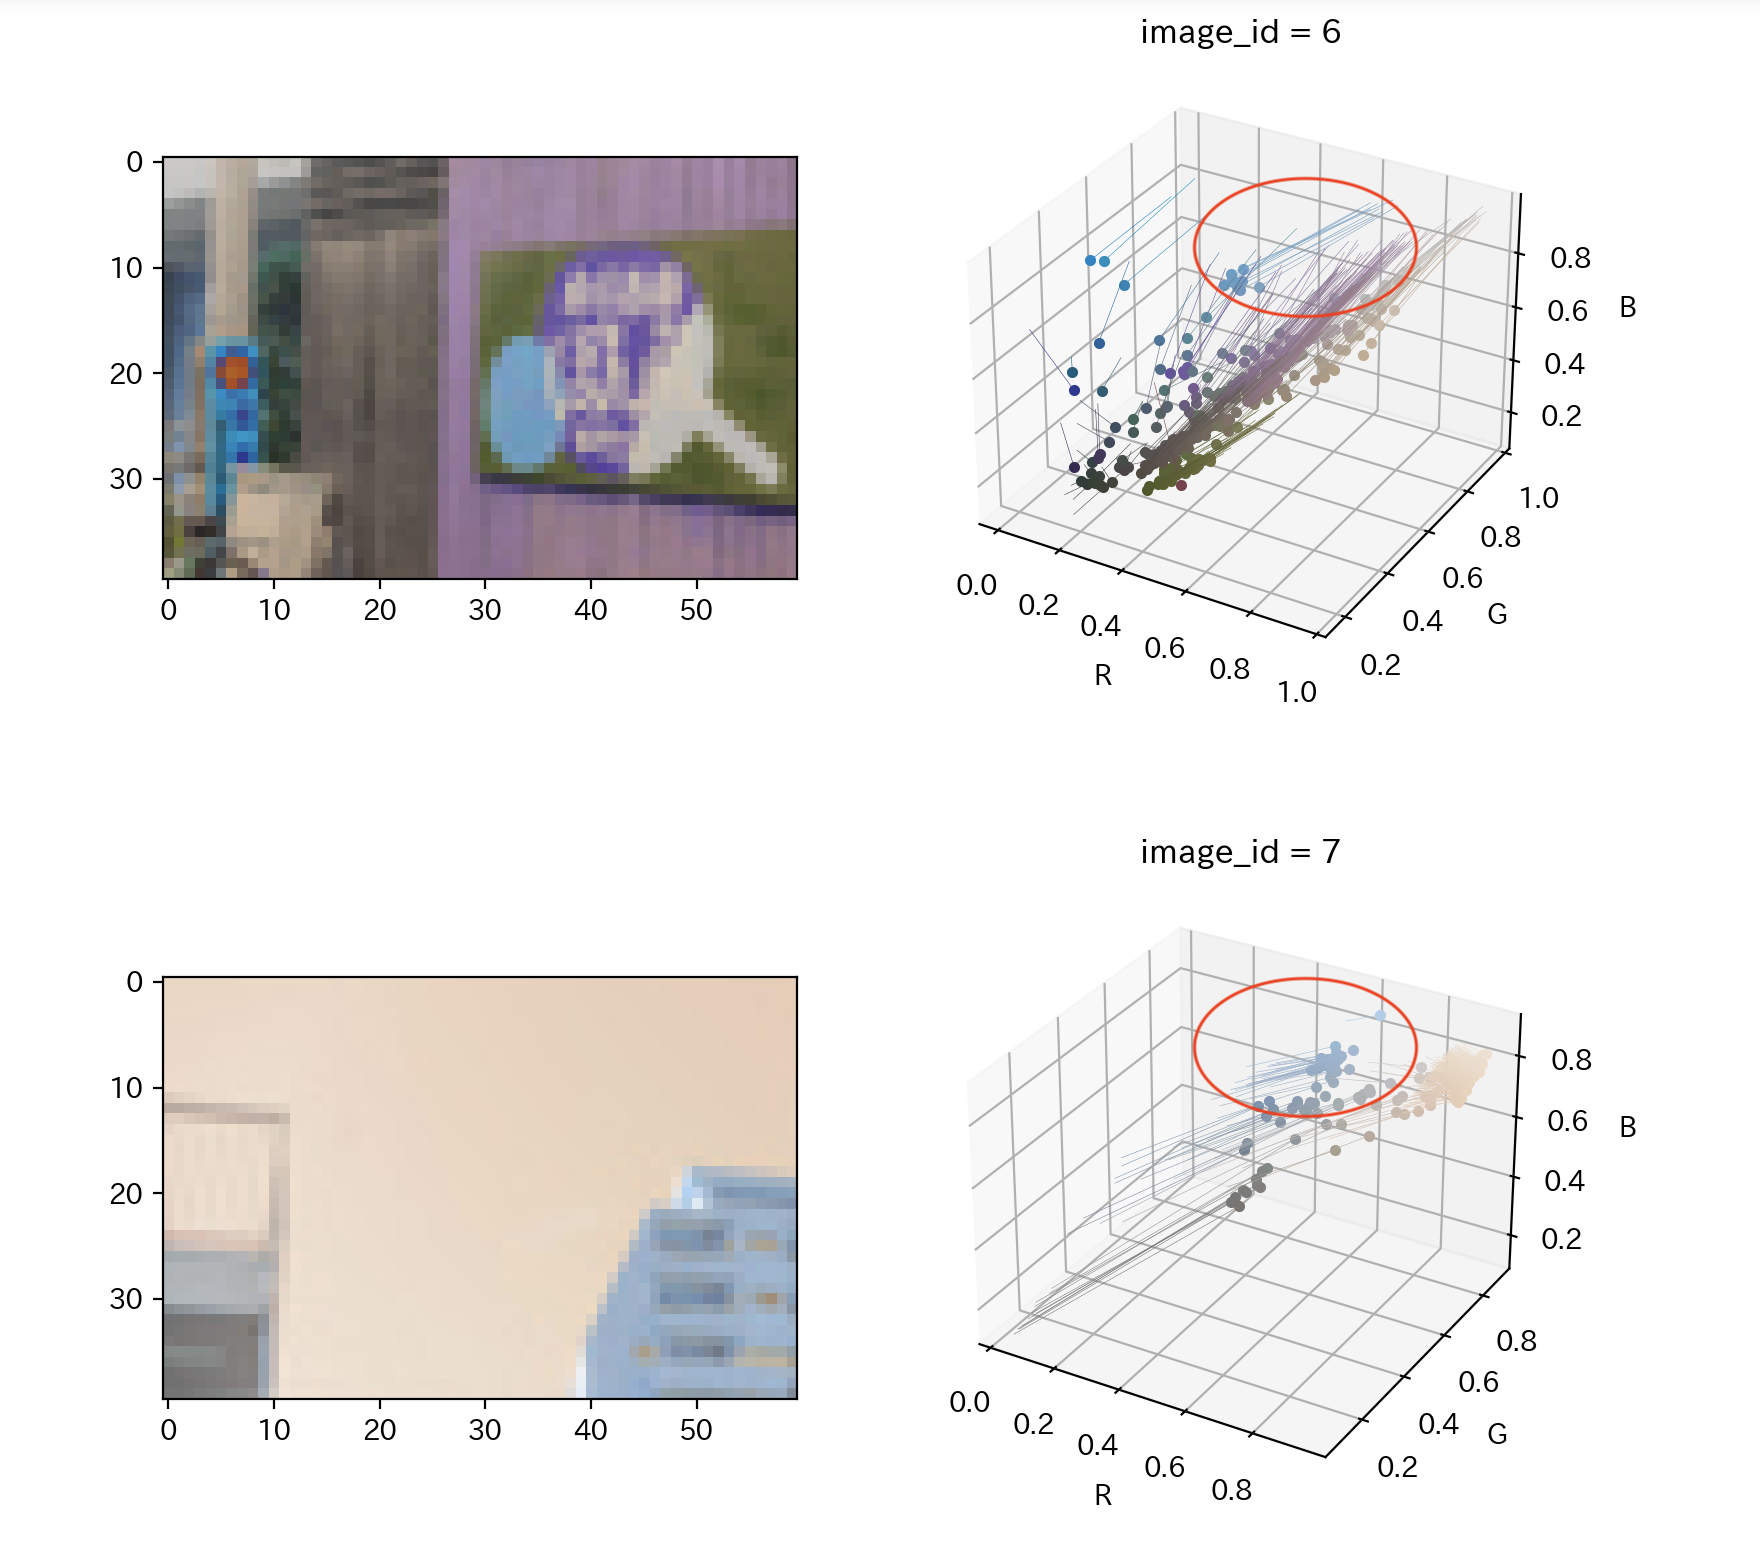
    
 なので、 06_x, y で学習したものを 07_x  に適用した場合、暗くなるべきところが明るくなってしまう。
つまり、写真ごとに変換は全く違うものになっている。

 考えられる理由としては、
 
 * 撮影条件が違う。
 * フィルムの現像条件が違う
 * XとYとで撮影条件(F値、シャッタースピード、WBなど)を揃えたとしても、撮影条件ごとに変換関数が変化する
 
など。

いずれにせよ、この写真だけではなんとも言えない。



# 考察

* 「どのようにデータを集めて何がしたいか」をもう少し考えた方が良さげ。
    * それによってできること・できないことが変わってくる。
* 単純な機械学習・信号処理の問題というより、ユースケースも含めた設計の方が重要そう。
 
 